In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import Counter
from sklearn.metrics import accuracy_score, log_loss

import pickle
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')
import lightgbm
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# read pickle
with open('./data/X.pickle', 'rb') as handle:
    X = pickle.load(handle)
    
with open('./data/y.pickle', 'rb') as handle:
    y = pickle.load(handle)

In [116]:
max_depth_tree =5
num_trees=10

m1 = lightgbm.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=1, max_depth=max_depth_tree,
        min_child_samples=1, min_child_weight=0, min_split_gain=0.0,
        n_estimators=num_trees, n_jobs=-1, num_leaves=31, objective="binary", 
        random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0,  )
m1.fit(X, y, verbose=1, eval_set = [(X,y)], init_score = [0]  * len(X))

res_1 = m1.predict(X)
res_1_prob = m1.predict_proba(X)

accuracy_score(res_1, y)

[1]	training's binary_logloss: 0.369754
[2]	training's binary_logloss: 0.316638
[3]	training's binary_logloss: 0.282993
[4]	training's binary_logloss: 0.245081
[5]	training's binary_logloss: 0.228174
[6]	training's binary_logloss: 0.198358
[7]	training's binary_logloss: 0.182951
[8]	training's binary_logloss: 0.212569
[9]	training's binary_logloss: 0.173461
[10]	training's binary_logloss: 0.16263


0.9511918274687855

In [117]:
# log likelihood loss
def log_loss_train(labels, preds): #preds here is not y_pred, it's the sum_linear_pred (raw pred, a.k.a log odd)
    preds = 1. / (1. + np.exp(-preds)) # sigmoid convert the regression pred to probability (i.e., [0,1] range)
    grad = preds - labels
    hess = preds * (1. - preds)
    return grad, hess


def log_loss_valid(labels, preds):
    preds = 1. / (1. + np.exp(-preds))
    return '_log_loss_',log_loss(labels, preds),True



m_ = lightgbm.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=1, max_depth=max_depth_tree,
        min_child_samples=1, min_child_weight=0, min_split_gain=0.0,
        n_estimators=num_trees, n_jobs=-1, num_leaves=31, objective=log_loss_train, metrics = ["binary", 'binary_error'], 
        random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

# fitting model 
m_.fit(X, y, verbose=1, eval_set = [(X,y)], eval_metric=log_loss_valid)

res_ = m_.predict(X)
res_prob = m_.predict_proba(X)

accuracy_score(res_, y)

[1]	training's binary_error: 0.169126	training's binary_logloss: 2.6015	training's _log_loss_: 0.369754
[2]	training's binary_error: 0.139614	training's binary_logloss: 1.76144	training's _log_loss_: 0.316638
[3]	training's binary_error: 0.103292	training's binary_logloss: 2.14285	training's _log_loss_: 0.282993
[4]	training's binary_error: 0.0885358	training's binary_logloss: 1.26876	training's _log_loss_: 0.245081
[5]	training's binary_error: 0.0851305	training's binary_logloss: 1.03233	training's _log_loss_: 0.228174
[6]	training's binary_error: 0.0737798	training's binary_logloss: 0.673541	training's _log_loss_: 0.198358
[7]	training's binary_error: 0.0658343	training's binary_logloss: 0.370674	training's _log_loss_: 0.182951
[8]	training's binary_error: 0.0703746	training's binary_logloss: 0.328558	training's _log_loss_: 0.212569
[9]	training's binary_error: 0.0590238	training's binary_logloss: 0.104922	training's _log_loss_: 0.173461
[10]	training's binary_error: 0.0556186	traini

0.9443813847900113

In [118]:
np.round(res_1_prob,4)

array([[1.    , 0.    ],
       [0.01  , 0.99  ],
       [0.0282, 0.9718],
       ...,
       [0.9839, 0.0161],
       [0.0355, 0.9645],
       [0.9649, 0.0351]])

In [124]:
res_prob_sigmoid =  1. / (1. + np.exp(-res_prob))

np.round(res_prob_sigmoid,4)

array([[1.    , 0.    ],
       [0.0268, 0.99  ],
       [0.0731, 0.9718],
       ...,
       [0.994 , 0.0161],
       [0.091 , 0.9645],
       [0.9868, 0.0351]])

In [129]:
res_1_prob[:,1]

array([0.00000000e+00, 9.89956671e-01, 9.71798239e-01, 9.98405902e-01,
       5.26054305e-02, 8.96336678e-02, 2.75023199e-02, 5.86294837e-03,
       7.17745562e-01, 9.86632889e-01, 9.14996164e-01, 9.94020752e-01,
       1.55255571e-03, 1.29811231e-02, 2.14908278e-01, 9.30919956e-01,
       1.26908902e-02, 1.35245250e-01, 7.29762468e-01, 7.77016706e-01,
       2.00175875e-01, 9.91150863e-01, 8.06926593e-01, 5.96970429e-01,
       8.83166889e-03, 6.11029627e-01, 7.12198966e-02, 9.26523266e-01,
       6.45156760e-03, 3.77171048e-02, 9.99718458e-01, 8.04545570e-01,
       4.45173953e-02, 6.04608235e-02, 2.15565024e-02, 7.12198966e-02,
       1.55255571e-03, 3.51335291e-01, 9.23097975e-01, 7.74031435e-02,
       9.74865287e-01, 3.10849893e-02, 9.98755169e-01, 9.26523266e-01,
       8.16411676e-03, 9.57898548e-02, 8.04545570e-01, 1.87215373e-01,
       5.17533102e-01, 1.09179070e-02, 3.64323240e-02, 9.99994096e-01,
       8.57306883e-01, 6.41846884e-03, 6.25520797e-01, 8.63702329e-01,
      

In [127]:
res_prob_sigmoid[:,1]

array([0.00000000e+00, 9.89956671e-01, 9.71798239e-01, 9.98405902e-01,
       5.26054305e-02, 8.96336678e-02, 2.75023199e-02, 5.86294837e-03,
       7.17745562e-01, 9.86632889e-01, 9.14996164e-01, 9.94020752e-01,
       1.55255571e-03, 1.29811231e-02, 2.14908278e-01, 9.30919956e-01,
       1.26908902e-02, 1.35245250e-01, 7.29762468e-01, 7.77016706e-01,
       2.00175875e-01, 9.91150863e-01, 8.06926593e-01, 5.96970429e-01,
       8.83166889e-03, 6.11029627e-01, 7.12198966e-02, 9.26523266e-01,
       6.45156760e-03, 3.77171048e-02, 9.99718458e-01, 8.04545570e-01,
       4.45173953e-02, 6.04608235e-02, 2.15565024e-02, 7.12198966e-02,
       1.55255571e-03, 3.51335291e-01, 9.23097975e-01, 7.74031435e-02,
       9.74865287e-01, 3.10849893e-02, 9.98755169e-01, 9.26523266e-01,
       8.16411676e-03, 9.57898548e-02, 8.04545570e-01, 1.87215373e-01,
       5.17533102e-01, 1.09179070e-02, 3.64323240e-02, 9.99994096e-01,
       8.57306883e-01, 6.41846884e-03, 6.25520797e-01, 8.63702329e-01,
      

In [126]:
np.round(res_prob,4)

array([[ 1152.4609, -1151.4609],
       [   -3.5908,     4.5908],
       [   -2.5398,     3.5398],
       ...,
       [    5.1113,    -4.1113],
       [   -2.3012,     3.3012],
       [    4.3142,    -3.3142]])

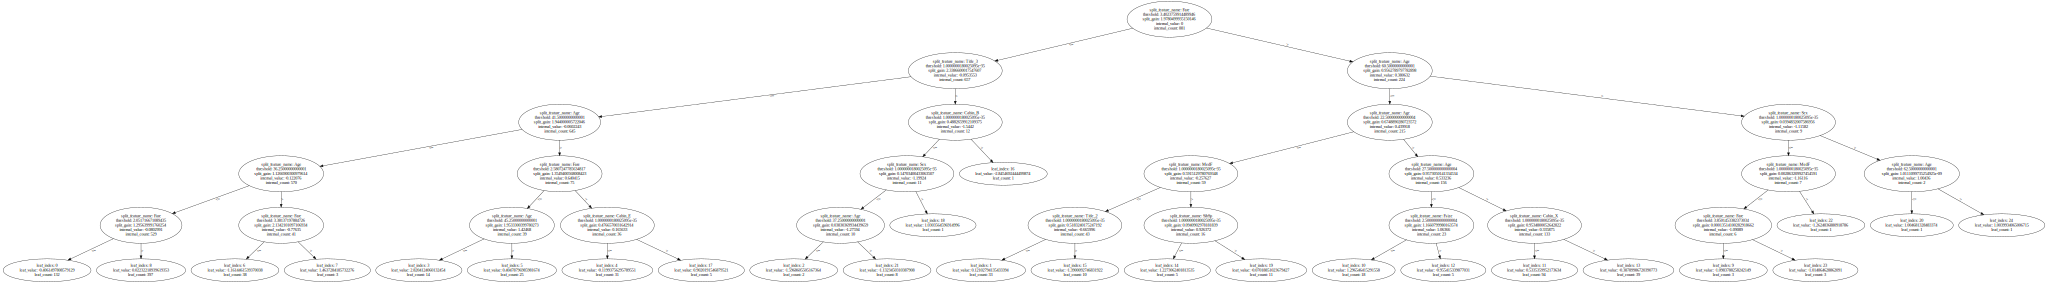

In [135]:
lightgbm.create_tree_digraph(m_, tree_index=9, show_info=["split_gain", "internal_value", "internal_count", "leaf_count"] )

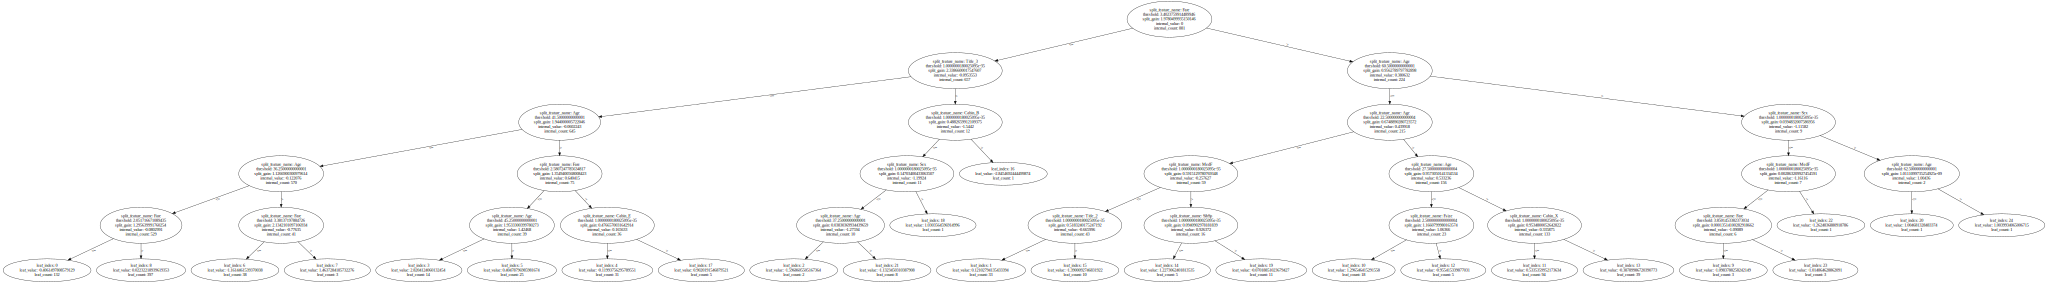

In [136]:
lightgbm.create_tree_digraph(m1, tree_index=9, show_info=["split_gain", "internal_value", "internal_count", "leaf_count"] )

In [20]:
import lightgbm as lgb


lgb_train = lgb.Dataset(X, y, free_raw_data=False)
lgb_eval = lgb.Dataset(X, y, free_raw_data=False)


# self-defined eval metric
# f(preds: array, train_data: Dataset) -> name: string, eval_result: float, is_higher_better: bool
# binary error
def binary_error(preds, train_data):
    labels = train_data.get_label()
    return 'binary_errorrr', np.mean(labels != (preds > 0.5)), False



def accuracy(preds, train_data):
    labels = train_data.get_label()
    return 'accuracy', np.mean(labels == (preds > 0.5)), True



def log_loss_(preds, train_data):
    y_preds = 1. / (1. + np.exp(-preds))
    labels = train_data.get_label()
    return 'log_loss_', log_loss(labels, y_preds), True



# log likelihood loss
def loglikelihood(preds, train_data): #preds here is not y_pred, it's the sum_linear_pred (raw pred)
    labels = train_data.get_label()
    preds = 1. / (1. + np.exp(-preds))
    grad = preds - labels
    hess = preds * (1. - preds)
    return grad, hess



params = {}
params = {}
params['learning_rate'] = 1
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary'
params['sub_feature'] = 1
params['num_leaves'] = 31
params['min_data'] = 0
params['max_depth'] = max_depth_tree
params['reg_alpha'] = 0
params['reg_lambda'] = 0

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=num_trees,
                fobj=loglikelihood,
                feval=lambda preds, train_data: [log_loss_(preds, train_data),
                                                 accuracy(preds, train_data)],
                valid_sets=lgb_train)

y_pred = gbm.predict(X, num_iteration=gbm.best_iteration)

print(1-np.mean(y != (y_pred > 0.5)))


temp = 1. / (1. + np.exp(-y_pred))
print(1-np.mean(y != (temp > 0.5)))

[1]	training's binary_logloss: 2.6015	training's log_loss_: 0.369754	training's accuracy: 0.830874
[2]	training's binary_logloss: 1.76144	training's log_loss_: 0.316638	training's accuracy: 0.860386
[3]	training's binary_logloss: 2.14285	training's log_loss_: 0.282993	training's accuracy: 0.896708
[4]	training's binary_logloss: 1.26876	training's log_loss_: 0.245081	training's accuracy: 0.911464
[5]	training's binary_logloss: 1.03233	training's log_loss_: 0.228174	training's accuracy: 0.914869
[6]	training's binary_logloss: 0.673541	training's log_loss_: 0.198358	training's accuracy: 0.92622
[7]	training's binary_logloss: 0.371114	training's log_loss_: 0.182951	training's accuracy: 0.934166
[8]	training's binary_logloss: 0.329367	training's log_loss_: 0.212572	training's accuracy: 0.929625
[9]	training's binary_logloss: 0.101863	training's log_loss_: 0.173463	training's accuracy: 0.940976
[10]	training's binary_logloss: -0.256271	training's log_loss_: 0.162633	training's accuracy: 0.94

[89]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[90]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[91]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[92]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[93]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[94]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[95]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[96]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[97]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[98]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy:

[173]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[174]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[175]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[176]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[177]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[178]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[179]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[180]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[181]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[182]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's

[281]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[282]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[283]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[284]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[285]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[286]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[287]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[288]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[289]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[290]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's

[375]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[376]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[377]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[378]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[379]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[380]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[381]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[382]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[383]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[384]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's

[496]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[497]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[498]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[499]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[500]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[501]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[502]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[503]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[504]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[505]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's

[592]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[593]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[594]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[595]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[596]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[597]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[598]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[599]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[600]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[601]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's

[682]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[683]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[684]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[685]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[686]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[687]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[688]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[689]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[690]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[691]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's

[781]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[782]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[783]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[784]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[785]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[786]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[787]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[788]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[789]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[790]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's

[871]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[872]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[873]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[874]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[875]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[876]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[877]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[878]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[879]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[880]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's

[962]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[963]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[964]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[965]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[966]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[967]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[968]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[969]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[970]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's accuracy: 0.785471
[971]	training's binary_logloss: -0.792212	training's log_loss_: 7.3343	training's

In [19]:
print(accuracy_score(res_2, y))
accuracy_score(res_2, y) == (1-np.mean(y != (y_pred > 0.5)))
(1-np.mean(y != (y_pred > 0.5)))

0.8910329171396141


0.547105561861521

In [ ]:
# lightgbm.create_tree_digraph(m2, tree_index=0, show_info=["split_gain", "internal_value", "internal_count", "leaf_count"] )

In [ ]:
# lightgbm.create_tree_digraph(gbm, tree_index=0, show_info=["split_gain", "internal_value", "internal_count", "leaf_count"] )

In [ ]:
def loglikelihood(preds, train_data):
    labels = train_data.get_label()
    preds = 1. / (1. + np.exp(-preds))
    grad = preds - labels
    hess = preds * (1. - preds)
    return grad, hess


# self-defined eval metric
# f(preds: array, train_data: Dataset) -> name: string, eval_result: float, is_higher_better: bool
# binary error
def binary_error(preds, train_data):
    labels = train_data.get_label()
    return 'error', np.mean(labels != (preds > 0.5)), False


print('Finished 40 - 50 rounds with self-defined objective function and eval metric...')


# another self-defined eval metric
# f(preds: array, train_data: Dataset) -> name: string, eval_result: float, is_higher_better: bool
# accuracy
def accuracy(preds, train_data):
    labels = train_data.get_label()
    return 'accuracy', np.mean(labels == (preds > 0.5)), True


gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                fobj=loglikelihood,
                feval=lambda preds, train_data: [binary_error(preds, train_data),
                                                 accuracy(preds, train_data)],
                valid_sets=lgb_eval)

In [ ]:
y_pred = gbm.predict(X, num_iteration=gbm.best_iteration) > 0.5
accuracy_score(y_pred, y)

objetive = binary   => regresson on (0,1) => 1.1 => sigmoid(1.1) (this is y_pred) => calc error => finish 1 round, return  y_pred=sigmoid(1.1) 

objetive = log_loss_customer_func   => regresson on (0,1) => 1.1 (this is y_pred) => sigmoid(1.1) => calc error => finish 1 round,  return  y_pred=1.1

hessian ?
how to find best split
how to minimize error after know index for best split